In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

# imported packages
from lineartree import LinearTreeClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

In [2]:
# create a toy dataset with two classes and two features
# based on (independent) Gaussian distributions

np.random.seed(0)

mu_x1, sigma_x1 = 0.1, 0.15 # mean and standard deviation
mu_y1, sigma_y1 = 0.8, 0.3
x = np.random.normal(mu_x1, sigma_x1, 500)
y = np.random.normal(mu_y1, sigma_y1, 500)

mu_x2, sigma_x2 = 1.25, 0.1 # mean and standard deviation
mu_y2, sigma_y2 = 0.5, 0.3
x_ = np.random.normal(mu_x2, sigma_x2, 500)
y_ = np.random.normal(mu_y2, sigma_y2, 500)

class_1x = np.concatenate((x, x_), axis = 0)
class_1y = np.concatenate((y, y_), axis = 0)

mu_x1, sigma_x1 = 0.4, 0.2 # mean and standard deviation
mu_y1, sigma_y1 = -0.4, 0.05
x = np.random.normal(mu_x1, sigma_x1, 500)
y = np.random.normal(mu_y1, sigma_y1, 500)

mu_x2, sigma_x2 = 0.7, 0.08 # mean and standard deviation
mu_y2, sigma_y2 = 0.6, 0.4
x_ = np.random.normal(mu_x2, sigma_x2, 500)
y_ = np.random.normal(mu_y2, sigma_y2, 500)

class_2x = np.concatenate((x, x_), axis = 0)
class_2y = np.concatenate((y, y_), axis = 0)

class_all  = []
for i in range(2000):
    if i < 1000:
        class_all.append("class 0")
    else:
        class_all.append("class 1")

x_all = ((np.concatenate((class_1x, class_2x), axis = 0)) * 1000)
y_all = ((np.concatenate((class_1y, class_2y), axis = 0)) * 1000)

dataframe = pd.DataFrame(x_all, columns=['feature1'])
dataframe["feature2"] = y_all
#dataframe[dataframe < 0] = 0
dataframe["class"] = class_all
#dataframe[dataframe == "NaN"] = 0

dataframe = (dataframe.astype({'feature1': 'int32', 'feature2': 'int32'}))
dataframe.info()

#print(dataframe.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   feature1  2000 non-null   int32 
 1   feature2  2000 non-null   int32 
 2   class     2000 non-null   object
dtypes: int32(2), object(1)
memory usage: 31.4+ KB


In [3]:
continuous_atts = ['feature1', 'feature2']
nominal_atts = []
ordinal_atts = []
# class attribute
target = 'class'
# predictive atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts

decode = {
    'class': {
        0: 'class 0', 1: 'class 1'
    }
}

prefix_sep = "_" # separator for one-hot encoding
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep=prefix_sep)
df_encoded_onehot = df_code.fit_transform(dataframe)
df_encoded_onehot.head()
df_code.encode, df_code.decode

({'class': {'class 0': 0, 'class 1': 1},
  'feature2': (-896, 1665),
  'feature1': (-315, 1567)},
 {'class': {0: 'class 0', 1: 'class 1'}})

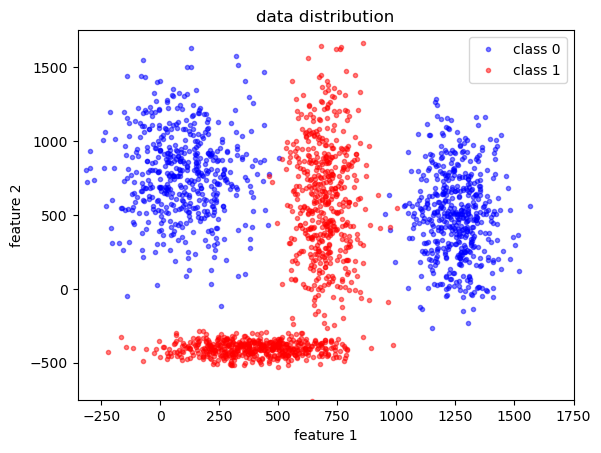

In [4]:
#count, bins, ignored = plt.hist(x, 30, density=True)
#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')

#plt.scatter(dataframe["feature1"], dataframe["feature2"], alpha=0.25)
#plt.scatter(class_2x, class_2y, c="green", alpha=0.25)

x_min, x_max, y_min, y_max = -350, 1750, -750, 1750

groups = dataframe.groupby('class')
#colours = ["green", "limegreen"]
colours = ["blue", "red"]
colour_index = 0

for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.5, color = colours[colour_index])
    colour_index=+1

plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("data distribution")
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [5]:
# ADJUSTMENTS: FIX RANDOM SEEDS FOR REPRODUCIBILITY

# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# split predictive and target
X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
X1, _, y1, _ = train_test_split(X, y, test_size=0.3, random_state=42)
X2, _, y2, _ = train_test_split(X, y, test_size=0.3, random_state=24)
# train a decision tree
clf1 = DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.001, random_state=0)
clf1.fit(X1, y1)

DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.001, random_state=0)

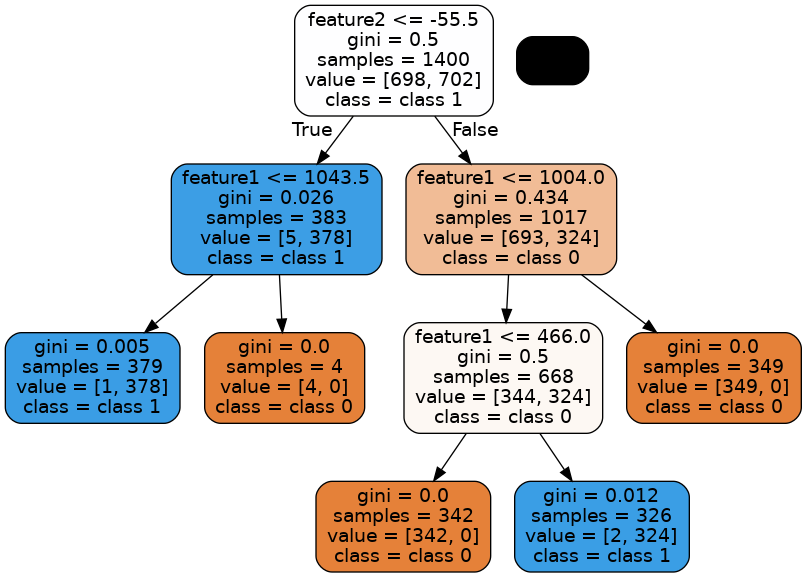

In [6]:
# visualize the decision tree
dot_data = tree.export_graphviz(clf1, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [7]:
from sklearn.tree import export_text
rules = export_text(clf1, feature_names=["feature1", "feature2"])

/home/laura/miniconda3/envs/clpmodular/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


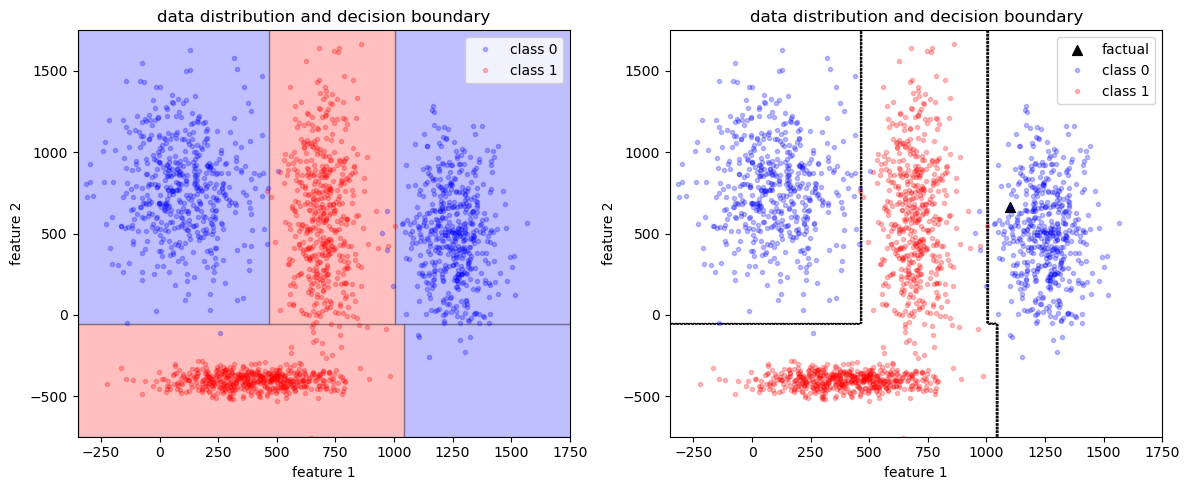

In [8]:
plt.figure(figsize=(12, 5))

#https://scikit-learn.org/0.24/auto_examples/tree/plot_iris_dtc.html

xx, yy = np.meshgrid(np.arange(x_min, x_max + 50, 10), np.arange(y_min, y_max + 50, 10))

Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html

# VERSION 1

plt.subplot(1, 2, 1)
#plt.contourf(xx, yy, Z, alpha=0.25, cmap=plt.cm.Greens)
#plt.contourf(xx, yy, Z, alpha=0.25, cmap=plt.cm.coolwarm)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("data distribution and decision boundary")

#plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

# PLOT ALL PARTIOTIONS
rect = plt.Rectangle((x_min, y_min), abs(1043.5 - x_min), abs(-55.5 - y_min), fill = True, alpha = 0.25, facecolor = "r", edgecolor = "k", linestyle = "-", linewidth = 1)
plt.gca().add_patch(rect)
rect = plt.Rectangle((1043.5, y_min), abs(x_max + 50 - 1043.5), abs(-55.5 - y_min), fill = True, alpha = 0.25, facecolor = "b", edgecolor = "k", linestyle = "-",linewidth = 1)
plt.gca().add_patch(rect)
rect = plt.Rectangle((x_min, -55.5), abs(466 - x_min), abs(y_max + 50 - (-55.5)), fill = True, alpha = 0.25, facecolor = "b", edgecolor = "k", linestyle = "-", linewidth = 1)
plt.gca().add_patch(rect)
rect = plt.Rectangle((466, -55.5), abs(1004 - 466), abs(y_max + 50 - (-55.5)), fill = True, alpha = 0.25, facecolor = "r", edgecolor = "k", linestyle = "-",linewidth = 1)
plt.gca().add_patch(rect)
rect = plt.Rectangle((1004, -55.5), abs(x_max + 50 - 1004), abs(y_max + 50 - (-55.5)), fill = True, alpha = 0.25, facecolor = "b", edgecolor = "k", linestyle = "-",linewidth = 1)
plt.gca().add_patch(rect)

plt.legend()

# VERSION 2

plt.subplot(1, 2, 2)

plt.contour(xx, yy, Z, linewidths=0.5, linestyles = "dashed", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("data distribution and decision boundary")

plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Model2CLP
r = reasonx.ReasonX(pred_atts, target, df_code)
r.model(clf1)

In [10]:
# factual rule on an instance
r.instance('F', features=X1.iloc[0:1], label=y1.iloc[0])
r.solveopt()

---
Answer constraint: F.feature1=1100.0,F.feature2=661.0
Rule satisfied by F: IF F.feature1>1004.0,F.feature2> -55.5 THEN class 0 [1.0000]


/home/laura/miniconda3/envs/clpmodular/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


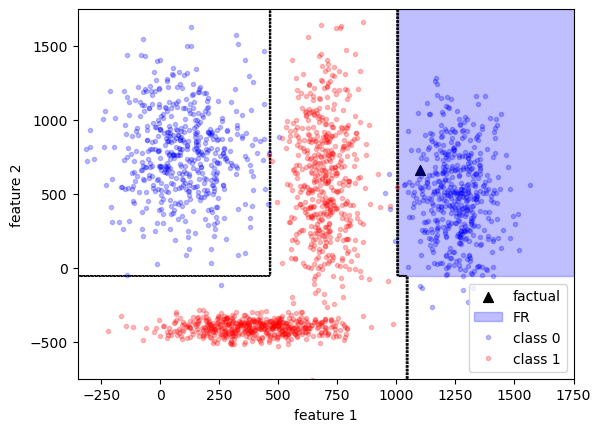

In [11]:
# DISPLAY THE RULE

# CASES
# 1) upper bounded by a > delta = abs(x_min - a) > (x_min), delta
# 2) lower bounded by a > delta = abs(x_max - a) > (a), delta
# 3) upper bounded by b, lower bounded by a > delta = abs(b - a) > (a), delta

#https://scikit-learn.org/0.24/auto_examples/tree/plot_iris_dtc.html

xx, yy = np.meshgrid(np.arange(x_min, x_max + 50, 10), np.arange(y_min, y_max + 50, 10))

Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")

plt.xlabel("feature 1")
plt.ylabel("feature 2")

plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

# manual translation into lines or squares
# Rule satisfied by F: IF F.feature1>1004.0,F.feature2> -55.5 THEN class0 [1.0000]

# CASE 2)
delta_x = abs(x_max - 1004)
x = 1004
# CASE 2)
delta_y = abs(y_max - (-55.5))
y = -55.5

rect = plt.Rectangle((x, y), delta_x, delta_y, fill = True, alpha = 0.25, color = "blue", label = "FR")
plt.gca().add_patch(rect)

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
#plt.title("factual region (rule)")

#plt.savefig("factual_region.pdf")

In [12]:
# counter-factual rules with min conf
r.instance('CF', label=1-y1.iloc[0], minconf=0.8)
r.solveopt()

---
Answer constraint: F.feature1=1100.0,F.feature2=661.0,CF.feature2<= -55.5,CF.feature1<=1043.5
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2<= -55.5,CF.feature1<=1043.5 THEN class 1 [0.9974]
---
Answer constraint: F.feature1=1100.0,F.feature2=661.0,CF.feature2> -55.5,CF.feature1>466.0,CF.feature1<=1004.0
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2> -55.5,CF.feature1>466.0,CF.feature1<=1004.0 THEN class 1 [0.9939]


/home/laura/miniconda3/envs/clpmodular/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


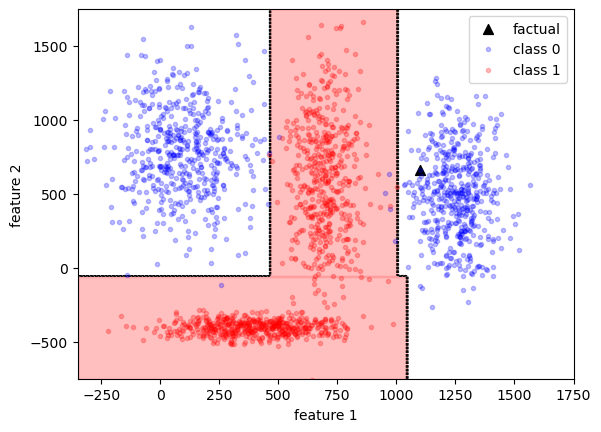

In [13]:
# colors: https://matplotlib.org/stable/gallery/color/named_colors.html

xx, yy = np.meshgrid(np.arange(x_min, x_max + 50, 10), np.arange(y_min, y_max + 50, 10))

Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

# RULE 1
#Rule satisfied by CE: IF CE.feature2<= -55.5,CE.feature1<=1043.5 THEN class 1 [0.9974]

delta_x = abs(x_min - 1043.5) 
delta_y = abs(y_min - -119.-55.5)

rect = plt.Rectangle((x_min, y_min), delta_x, delta_y, fill = True, alpha = 0.25, color = "red")
plt.gca().add_patch(rect)

# RULE 3
#Rule satisfied by CE: IF CE.feature2> -55.5,CE.feature1>466.0,CE.feature1<=1004.0 THEN class 1 [0.9939]


delta_x = abs(1004 - 466)
delta_y = abs(x_max - -55.5)
x = 466
y = -55.5

rect = plt.Rectangle((x, y), delta_x, delta_y, fill = True, alpha = 0.25, color = "red")
plt.gca().add_patch(rect)

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
#plt.title("admissible contrastive regions (rules)")

#plt.savefig("contrastive_region.pdf")

In [14]:
# set user constraints
r.constraint("CF.feature2 = F.feature2") # keep feature 2 constant > only one admissible region for CE
print("condition 1")
r.solveopt() 

r.retract("CF.feature2 = F.feature2") 
r.constraint("CF.feature1 = F.feature1") # keep feature 1 constant > no admissible region for CE
print("condition 2")
r.solveopt()

condition 1
---
Answer constraint: F.feature1=1100.0,F.feature2=661.0,CF.feature2=661.0,CF.feature1>466.0,CF.feature1<=1004.0
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2> -55.5,CF.feature1>466.0,CF.feature1<=1004.0 THEN class 1 [0.9939]
1 constraints retracted
condition 2
No answer.


/home/laura/miniconda3/envs/clpmodular/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


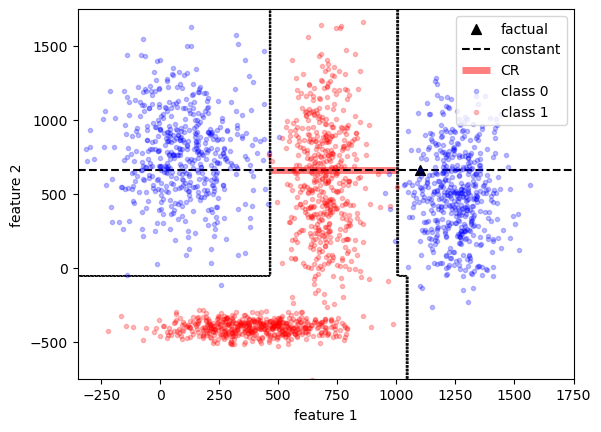

In [15]:
# colors: https://matplotlib.org/stable/gallery/color/named_colors.html

#plt.figure(figsize=(12, 5))

xx, yy = np.meshgrid(np.arange(x_min, x_max + 50, 10), np.arange(y_min, y_max + 50, 10))

Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#plt.subplot(1, 2, 1)

plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

plt.hlines(X1.iloc[0:1]["feature2"], x_min, x_max, color = "black", label = "constant", linestyles="--")

# Answer constraint: F.feature1=1100.0,F.feature2=661.0,CF.feature2=661.0,CF.feature1>=466.0,CF.feature1<=1004.0

f_feature1_upper = 1004
f_feature1_lower = 466
plt.hlines(661.0, f_feature1_lower, f_feature1_upper, colors="red", zorder = 1, linewidth = 5, alpha = 0.5, label = "CR")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.title("admissible contrastive regions (rules), condition 1")
plt.legend()

#plt.savefig("contrastive_regions_condition1.pdf")

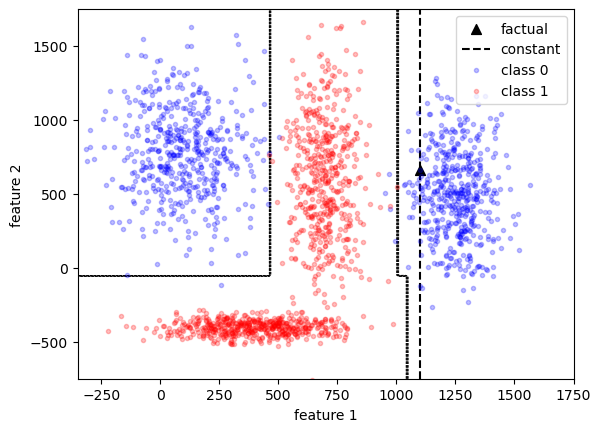

In [16]:
#plt.subplot(1, 2, 2)

plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

plt.vlines(X1.iloc[0:1]["feature1"], y_min, y_max, color = "black", label = "constant", linestyles="--")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.title("admissible contrastive regions (rules), condition 2")
plt.legend()

#plt.savefig("contrastive_regions_condition2.pdf")

In [17]:
r.retract("CF.feature1 = F.feature1") 
r.constraint("CF.feature2 = F.feature2")
print("condition 3")
r.solveopt(minimize='l1norm(F, CF)')

r.retract("CF.feature2 = F.feature2") 
r.constraint("CF.feature2 = CF.feature1")
print("condition 4")
r.solveopt(minimize='l1norm(F, CF)')

1 constraints retracted
condition 3
---
Answer constraint: F.feature1=1100.0,F.feature2=661.0,CF.feature1=1003.9999999999999,CF.feature2=661.0
Min value: 0.051009564293305054
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2> -55.5,CF.feature1>466.0,CF.feature1<=1004.0 THEN class 1 [0.9939]
1 constraints retracted
condition 4
---
Answer constraint: F.feature1=1100.0,F.feature2=661.0,CF.feature1= -55.5,CF.feature2= -55.5
Min value: 0.8937480211842728
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2<= -55.5,CF.feature1<=1043.5 THEN class 1 [0.9974]
---
Answer constraint: F.feature1=1100.0,F.feature2=661.0,CF.feature1=1004.0,CF.feature2=1004.0
Min value: 0.1849416220832308
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2> -55.5,CF.feature1>466.0,CF.feature1<=1004.0 THEN class 1 [0.99

In [18]:
r.minvalues()

[0.8937480211842728, 0.1849416220832308]

/home/laura/miniconda3/envs/clpmodular/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


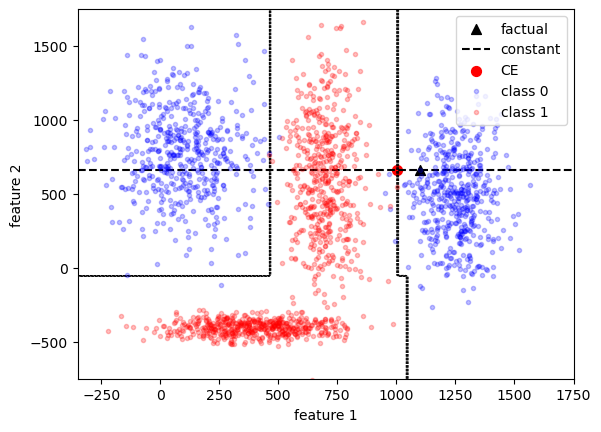

In [19]:
# colors: https://matplotlib.org/stable/gallery/color/named_colors.html

#plt.figure(figsize=(12, 5))

xx, yy = np.meshgrid(np.arange(x_min, x_max + 50, 10), np.arange(y_min, y_max + 50, 10))

Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#plt.subplot(1, 2, 1)

plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

plt.hlines(X1.iloc[0:1]["feature2"], x_min, x_max, color = "black", label = "constant", linestyles="--")

# RESULTS
# CF.feature1=1003.9999999999999,CF.feature2=661.0

cf_feature1=1003.9999999999999
cf_feature2=661.0

plt.scatter(cf_feature1, cf_feature2, c="red", marker="o", zorder=1, s = 50, label = "CE")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.title("closest CE, condition 3")
plt.legend()

#plt.savefig("contrastive_regions_condition3.pdf")

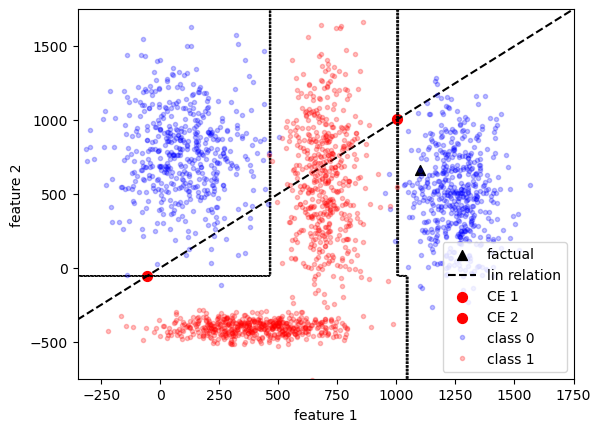

In [20]:
#plt.subplot(1, 2, 2)

plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

plt.scatter(X1.iloc[0:1]["feature1"], X1.iloc[0:1]["feature2"], c="black", marker="^", zorder=1, s = 50, label = "factual")

x_linear = np.linspace(x_min, x_max, 50)
y_linear = x_linear

plt.plot(x_linear, y_linear, color = "black", label = "lin relation", linestyle = "dashed")

# CF.feature1= -55.5,CF.feature2= -55.5

cf_feature1= -55.5
cf_feature2= -55.5

plt.scatter(cf_feature1, cf_feature2, c="red", marker="o", zorder=1, s = 50, label = "CE 1")

# CF.feature1=1004.0,CF.feature2=1004.0

cf_feature1=1004.0
cf_feature2=1004.0

plt.scatter(cf_feature1, cf_feature2, c="red", marker="o", zorder=1, s = 50, label = "CE 2")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.title("closest CE, condition 4")
plt.legend()

#plt.savefig("contrastive_regions_condition4.pdf")

In [21]:
r.retract("CF.feature2 = CF.feature1") 
f_feature2 = X1.iloc[0:1]["feature2"].item()
r.retract("F.feature2 = " + str(f_feature2))
r.constraint("F.feature2 >= " + str(f_feature2 - 500))
r.constraint("F.feature2 <= " + str(f_feature2 + 500))
print("condition 5")
r.solveopt(minimize='l1norm(F, CF)')
#r.solveopt()

1 constraints retracted
1 constraints retracted
condition 5
---
Answer constraint: F.feature1=1100.0,F.feature2=161.0,CF.feature1=1043.5,CF.feature2= -55.5
Min value: 0.11455854410616872
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2<= -55.5,CF.feature1<=1043.5 THEN class 1 [0.9974]
---
Answer constraint: F.feature1=1100.0,CF.feature1=1003.9999999999999,F.feature2>=161.0,F.feature2<=1161.0,CF.feature2=F.feature2
Min value: 0.051009564293305054
Rule satisfied by F: IF F.feature2> -55.5,F.feature1>1004.0 THEN class 0 [1.0000]
Rule satisfied by CF: IF CF.feature2> -55.5,CF.feature1>466.0,CF.feature1<=1004.0 THEN class 1 [0.9939]


/home/laura/miniconda3/envs/clpmodular/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


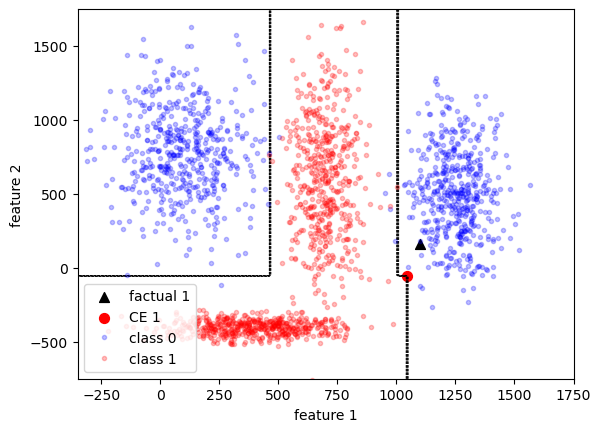

In [22]:
# colors: https://matplotlib.org/stable/gallery/color/named_colors.html

#plt.figure(figsize=(15, 5))

xx, yy = np.meshgrid(np.arange(x_min, x_max + 50, 10), np.arange(y_min, y_max + 50, 10))

Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#plt.subplot(1, 3, 1)

plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

# RESULTS PART 1
plt.scatter(1100.0, 161.0, c="black", marker="^", zorder=1, s = 50, label = "factual 1")
plt.scatter(1043.5, -55.5, c="red", marker="o", zorder=1, s = 50, label = "CE 1")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.title("closest CE, condition 5")
plt.legend(loc = "lower left")

#plt.savefig("contrastive_regions_condition5_1.pdf")

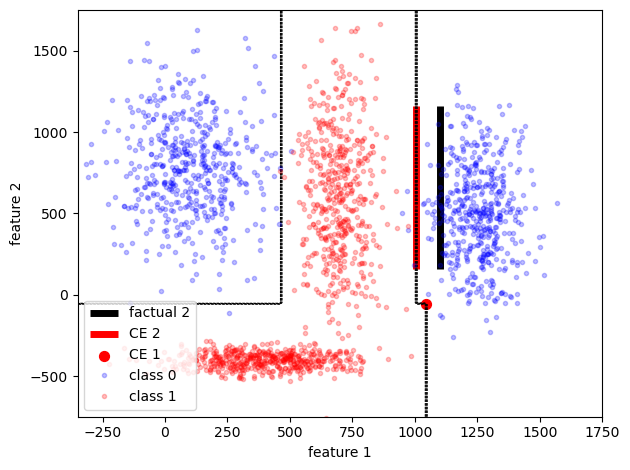

In [23]:
#plt.subplot(1, 3, 3)

plt.contour(xx, yy, Z, linewidths=0.5, linestyles="--", colors = "black")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

# RESULTS PART 3
plt.vlines(X1.iloc[0:1]["feature1"], f_feature2 - 500, f_feature2 + 500, colors="black", zorder = 1, label = "factual 2", linewidth = 5)

# F.feature1=1100.0,CF.feature1=1003.9999999999999,F.feature2>=161.0,F.feature2<=1161.0,CF.feature2=F.feature2

plt.vlines(1003.9999999999999, f_feature2 - 500, f_feature2 + 500, colors="red", zorder = 1, label = "CE 2", linewidth = 5)

# ADD FIRST ANSWER
plt.scatter(1043.5, -55.5, c="red", marker="o", zorder=1, s = 50, label = "CE 1")

colour_index = 0
for name, group in groups:
    plt.plot(group.feature1, group.feature2, marker='o', linestyle='', markersize=3, label=name, alpha=0.25, color = colours[colour_index])
    colour_index=+1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.title("closest CE, condition 5")
plt.legend(loc = "lower left")
plt.tight_layout()

#plt.savefig("contrastive_regions_condition5_3.pdf")